In [ ]:
import numpy as np

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_data = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [ ]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression()

In [ ]:
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [ ]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정.
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)
print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9386
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9298
에이다부스트 정확도: 0.9737


In [ ]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과로 피처로 만듬.
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [ ]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9649


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화.
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
      # 입력된 학습 데이터에서 기반 모델이 학습 / 예측할 폴드 데이터 세트 추출
      print('\t 폴드 세트:', folder_counter, '시작')
      X_tr = X_train_n[train_index]
      y_tr = y_train_n[train_index]
      X_te = X_train_n[valid_index]

      # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
      model.fit(X_tr, y_tr)
      # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
      train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
      # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장.
      test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)
    return train_fold_pred, test_pred_mean

In [ ]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
RandomForestClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
DecisionTreeClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작
AdaBoostClassifier model 시작
	 폴드 세트: 0 시작
	 폴드 세트: 1 시작
	 폴드 세트: 2 시작
	 폴드 세트: 3 시작
	 폴드 세트: 4 시작
	 폴드 세트: 5 시작
	 폴드 세트: 6 시작


In [ ]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:', X_train.shape, '원본 테스트 피처 Shape:', X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape, '스태킹 테스트 피처 Shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 Shape: (114, 4)


In [ ]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9649


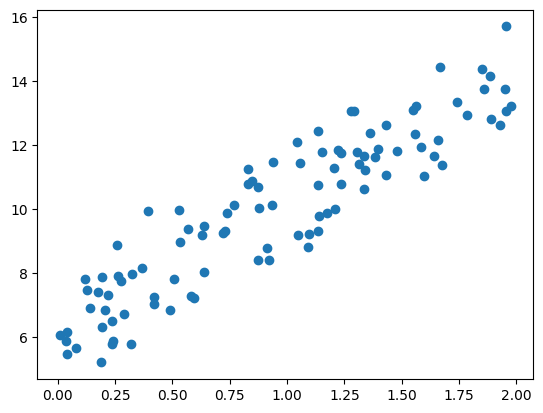

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
X = 2 * np.random.rand(100, 1)
y = 6 + 4 * X+np.random.randn(100, 1)
plt.scatter(X, y)